In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
from cache import cache

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
#pip install pycocotools

In [4]:
import coco

In [5]:
#coco.maybe_download_and_extract()

In [6]:
_, filenames_train, captions_train = coco.load_records(train=True)

- Data loaded from cache-file: data/coco/records_train.pkl


In [7]:
num_images_train = len(filenames_train)
#num_images_train

In [8]:
_, filenames_val, captions_val = coco.load_records(train=False)

- Data loaded from cache-file: data/coco/records_val.pkl


In [9]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not None.
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [10]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set.
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

In [11]:
#show_image(idx=1, train=True)

In [12]:
image_model = VGG16(include_top=True, weights='imagenet')
#include_top=True, weights='imagenet'
#image_model.summary()

In [13]:
transfer_layer = image_model.get_layer('fc2')

In [14]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

In [15]:
img_size = K.int_shape(image_model.input)[1:3]
#img_size

In [16]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
#transfer_values_size

In [17]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [18]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

In [19]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir,
                            filenames=filenames_train)

    return transfer_values

In [20]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values

In [21]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 118287 images in training-set ...
- Data loaded from cache-file: data/coco/transfer_values_train.pkl
dtype: float16
shape: (118287, 4096)
Wall time: 10.5 s


In [22]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 5000 images in validation-set ...
- Data loaded from cache-file: data/coco/transfer_values_val.pkl
dtype: float16
shape: (5000, 4096)
Wall time: 402 ms


In [23]:
mark_start = 'ssss '
mark_end = ' eeee'

In [24]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

In [25]:
captions_train_marked = mark_captions(captions_train)
#captions_train_marked[0]

In [26]:
#captions_train[0]

In [27]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

In [28]:
captions_train_flat = flatten(captions_train_marked)

In [29]:
num_words = 10000

In [30]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

In [31]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

Wall time: 10.8 s


In [32]:
token_start = tokenizer.word_index[mark_start.strip()]
#token_start

In [33]:
token_end = tokenizer.word_index[mark_end.strip()]
#token_end

In [34]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

Wall time: 9.61 s


In [35]:
#tokens_train[0]

In [36]:
#captions_train_marked[0]

In [37]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))

        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

In [38]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list of random indices for images in the training-set.
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens.
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1]
        decoder_output_data = tokens_padded[:, 1:]

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

In [39]:
batch_size = 384

In [40]:
generator = batch_generator(batch_size=batch_size)

In [41]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [42]:
#batch_x['transfer_values_input'][0]

In [43]:
#batch_x['decoder_input'][0]

In [44]:
#batch_y['decoder_output'][0]

In [45]:
num_captions_train = [len(captions) for captions in captions_train]

In [46]:
total_num_captions_train = np.sum(num_captions_train)

In [47]:
steps_per_epoch = int(total_num_captions_train / batch_size)
#steps_per_epoch

In [48]:
state_size = 512

In [49]:
embedding_size = 128

In [50]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

In [51]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

In [52]:
decoder_input = Input(shape=(None, ), name='decoder_input')

In [53]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

In [54]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

In [55]:
decoder_dense = Dense(num_words,
                      activation='softmax',
                      name='decoder_output')

In [56]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [57]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [58]:
decoder_model.compile(optimizer=RMSprop(lr=1e-3),
                      loss='sparse_categorical_crossentropy')

In [59]:
path_checkpoint = '22_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [60]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [61]:
callbacks = [callback_checkpoint, callback_tensorboard]

In [62]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [63]:
%%time
decoder_model.fit(x=generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=0,
                  callbacks=callbacks)

Wall time: 1.03 s


In [64]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    #plt.imshow(image)
    #plt.show()
    
    # Print the predicted caption.
    #print("Predicted caption:")
    #print(output_text)
    #print()
    return output_text

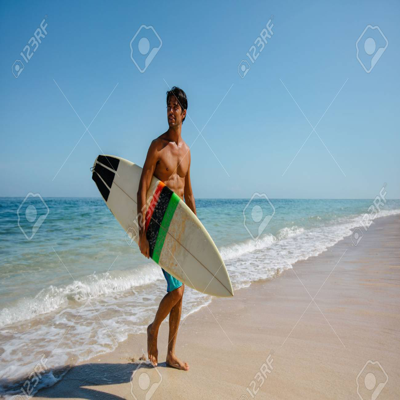

 a man in a wetsuit surfing on a wave eeee


In [98]:
#image_path="muho.jpeg"
#image_path="car.jpg"
#image_path="dog.jpg"
#image_path="kitchen.jpg"
#image_path="sofra.jpg"
#image_path="suit.jpg"
image_path="surf.jpg"
i=Image.open(image_path)
i=i.resize((400, 400))
caption=generate_caption(image_path)
display(i)
print(caption)